In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

import random
random.seed(1987)

case grids:
```bash
/data100t1/home/wanying/BioVU/202505_hypophosphatasia/data/hpp_icd_code_counts_in_sd.case_only.csv
```

SD demographic:
```bash
/data100t1/share/synthetic-deriv/demographic-releases/2025-mar-19/sd_demographics.csv.gz
```

In [2]:
case_path = Path('/data100t1/home/wanying/BioVU/202505_hypophosphatasia/data/hpp_icd_code_counts_in_sd.case_only.csv')
sd_demo_path = Path('/data100t1/share/synthetic-deriv/demographic-releases/2025-mar-19/sd_demographics.csv.gz')
sd_phecode_path = Path('/data100t1/share/synthetic-deriv/phecodes/all-sd-phecodes-mar-2025/all-sd-codes.csv.gz')
depth_of_record_path = Path('/data100t1/home/wanying/BioVU/202505_hypophosphatasia/data/depth_of_record_in_sd.csv')

case_df = pd.read_csv(case_path)
sd_demo_df = pd.read_csv(sd_demo_path)
# sd_phecode_df = pd.read_csv(sd_phecode_path)
depth_df = pd.read_csv(depth_of_record_path)

display(case_df.shape)
display(case_df.head())

display(sd_demo_df.shape)
display(sd_demo_df.head())

# display(sd_phecode_df.head())

display(depth_df.shape)
display(depth_df.head())

(21091, 2)

,grid,count_hpp_icd_code
0,R299892612,1
1,R299896297,1
2,R299896894,1
3,R299903282,1
4,R299904906,1


(3965634, 5)

,grid,birth_datetime,gender_source_value,ethnicity_source_value,race_source_value
0,R200000048,2002-03-29T00:00:00.000-06:00,F,NH,B
1,R200000050,1950-08-27T00:00:00.000-05:00,F,NH,U
2,R200000069,1970-07-13T00:00:00.000-05:00,F,NT,W
3,R200000084,1937-06-18T00:00:00.000-05:00,F,NT,W
4,R200000141,1999-07-14T00:00:00.000-05:00,M,UN,U


(3560216, 2)

,grid,depth_of_record
0,R200000048,17
1,R200000069,113
2,R200000084,71
3,R200000141,2
4,R200000176,2


In [3]:
test_case_df = case_df.iloc[:100]
test_case_df.shape

(100, 2)

In [ ]:
test_grid_list = test_case_df.grid.to_list()
test_depth_df = depth_df[depth_df.grid.isin(test_grid_list)]
test_demo_df = sd_demo_df[sd_demo_df.grid.isin(test_grid_list)]

In [4]:
test_case_df.to_csv('../data/test_case.csv', index=False)

In [7]:
df_phecode = pd.read_csv('/data100t1/share/synthetic-deriv/phecodes/all-sd-phecodes-mar-2025/sd_samples_phecode.binary.txt.gz', sep='\t')
df_phecode.head()

,grid,008,008.5,008.51,008.52,008.6,008.7,010,031,031.1,...,986,987,988,989,990,994,994.1,994.2,994.21,996
0,R200000048,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,R200000069,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,R200000084,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,R200000141,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,R200000176,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
case_df_2 = case_df[case_df.count_hpp_icd_code>1]
case_df_2.shape

(9476, 2)

In [4]:
def find_match_controls(case_of_interest, cases_df, controls_df):
    '''
    Find matching controls for the cases
    SEX, RACE, ETH matched
    AGE: +/- 5 year-old
    VISIT_COUNT: +/- 5 visits
    '''
    case = cases_df[cases_df.grid==case_of_interest]
    sex = case.gender_source_value.iloc[0]
    age_in_days = case.age_in_days.iloc[0]
    eth = case.ethnicity_source_value.iloc[0]
    race = case.race_source_value.iloc[0]
    depth_of_record = case.depth_of_record.iloc[0]

    mask = ((controls_df.gender_source_value == sex) &
            (controls_df.race_source_value == race) &
            (controls_df.ethnicity_source_value == eth) &
            (controls_df.age_in_days < age_in_days + 365 * 5) &
            (controls_df.age_in_days > age_in_days - 365 * 5) &
            (controls_df.depth_of_record < depth_of_record + 5) &
            (controls_df.depth_of_record > depth_of_record - 5)
           )
    controls_matched = list(controls_df[mask].grid)
    return controls_matched, controls_df[mask]


In [3]:
sd_info_df = sd_demo_df.merge(depth_df, on='grid')

sd_info_df['birthday'] = pd.to_datetime(sd_info_df['birth_datetime'], utc=True)
now = pd.Timestamp.now(tz='UTC')
sd_info_df['age_in_days'] = (now - sd_info_df['birthday']).dt.days

case_with_info_df = sd_info_df[sd_info_df.grid.isin(case_df.grid)]
control_with_info_df = sd_info_df[~sd_info_df.grid.isin(case_df.grid)]

In [4]:
case_with_info_df.to_csv('../data/hpp_case_sd.csv', sep='\t', index=False)
control_with_info_df.to_csv('../data/hpp_contrl_sd.csv', sep='\t', index=False)

In [11]:
found_controls = set()
header = ['case'] + [f'Control{i}' for i in range(1, 11)]
fh = open('../results/case_control_pairs1.txt', 'w')
fh.write('\t'.join(header))
fh.write('\n')
for case in tqdm(case_with_info_df.grid):
    # control_with_info_updated_df = control_with_info_df[~control_with_info_df.grid.isin(found_controls)]
    potential_matches, _ = find_match_controls(case, case_with_info_df, control_with_info_df)
    exclusive_matches = [x for x in potential_matches if x not in found_controls]
    random.shuffle(exclusive_matches)
    exclusive_matches_10 = exclusive_matches[:10]
    found_controls.update(exclusive_matches_10)
    line = '\t'.join([case] + exclusive_matches_10) + '\n'
    fh.write(line)
fh.close()

  0%|          | 5/21091 [00:09<11:38:51,  1.99s/it]


KeyboardInterrupt: 

## Check matched controls

In [3]:
case_control_pairs = pd.read_csv('../results/case_control_pairs_icd_count_5.txt', sep='\t')
case_control_pairs.head()

,case,Control1,Control2,Control3,Control4,Control5,Control6,Control7,Control8,Control9,Control10
0,R200023025,R296668804,R273525345,R294081179,R290356366,R230915167,R217641288,R287398432,R267339172,R275010963,R232574649
1,R200050438,R206041459,R215104613,R225240034,R239941645,R207534801,R258344263,R201023964,R209072742,R226082231,R239153451
2,R200052245,R243253711,R202920801,R275733745,R294107192,R268660085,R296350170,R280961997,R238572469,R268602757,R281916434
3,R200110729,R213706990,R264249889,R214840193,R264079016,R258414618,R289698136,R218849842,R265716192,R226523785,R267346757
4,R200118194,R279320203,R270441587,R221508582,R230660034,R217124414,R278146739,R217153755,R211297962,R291886747,R227444572


In [4]:
case_control_pairs.shape, case_control_pairs.dropna().shape

((2982, 11), (2157, 11))

In [5]:
number_of_missing = case_control_pairs.isna().sum()

In [6]:
number_of_missing.sum()

6128

In [7]:
number_of_missing

case           0
Control1     277
Control2     397
Control3     492
Control4     570
Control5     629
Control6     679
Control7     720
Control8     751
Control9     788
Control10    825
dtype: int64

In [8]:
29820-6128

23692

In [6]:
case_control_pairs.iloc[:,:2].dropna().shape

(19699, 2)

In [7]:
np.random.choice([],1)

ValueError: 'a' cannot be empty unless no samples are taken

In [1]:
d = {'a':1, 'b':2}

In [3]:
list(d.keys())

['a', 'b']

## Generate statistics

In [9]:
results = pd.read_csv('../results/icd_count_5.frequencies_and_pval.txt', sep='\t', dtype={'phecode':str})
results_sig = results[results.pval<1e-5]

/tmp/ipykernel_1446656/999468816.py:1: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,

In [10]:
results_sig.head()

,phecode,pval,case_freq,control_freq_1,control_freq_2,control_freq_3,control_freq_4,control_freq_5,control_freq_6,control_freq_7,...,control_freq_991,control_freq_992,control_freq_993,control_freq_994,control_freq_995,control_freq_996,control_freq_997,control_freq_998,control_freq_999,control_freq_1000
1,008,0.0,488,296,293,300,290,296,294,276,...,289,275,310,312,296,275,295,294,268,308
2,008.5,0.0,268,109,108,107,126,116,109,103,...,114,106,129,125,116,106,113,127,118,132
3,008.51,0.0,23,5,9,4,3,3,6,6,...,3,6,5,4,7,2,3,5,4,5
4,008.52,0.0,222,81,77,77,92,90,74,75,...,86,83,96,90,79,85,71,97,88,97
5,008.6,0.0,242,144,159,154,139,145,162,150,...,144,137,156,143,164,137,148,132,134,147


In [11]:
results.shape, results_sig.shape

((1877, 1003), (665, 1003))

In [29]:
840/1877

0.447522642514651

In [12]:
enriched_phecodes = pd.read_csv('../results/hpp_icd_count_5_enriched_phecode.csv', sep='\t', dtype={'Phecode':str})

In [13]:
enriched_phecodes.shape

(665, 13)

In [15]:
enriched_phecodes[enriched_phecodes.Count>30].shape

(636, 13)

In [16]:
enriched_phecodes = enriched_phecodes[enriched_phecodes.Count>30]
enriched_phecodes.to_csv('../results/hpp_icd_count_5_enriched_phecode_updated.csv', sep='\t', index=False)

In [33]:
enriched_phecodes.dtypes

Phecode                   object
Description               object
Count                      int64
p.value                  float64
p01                        int64
p05                        int64
p10                        int64
p50                        int64
p90                        int64
p95                        int64
p99                        int64
max                        int64
case_to_control_ratio    float64
dtype: object

In [30]:
enriched_phecodes.shape

(636, 13)

In [31]:
636/1877

0.33883857218966434

In [21]:
enriched_phecodes[enriched_phecodes.Phecode=='275']

,Phecode,Description,Count,p.value,p01,p05,p10,p50,p90,p95,p99,max,case_to_control_ratio
11,275,Disorders of mineral metabolism,2705,0.0,492,504,509,532,554,562,575,581,4.66


In [23]:
def plot_freq_dist(results: pd.DataFrame, folder: str, count: bool = False, N: int = 1762) -> None:
    """
    Plot frequency distributions for each phecode in the results DataFrame.
    
    Args:
        results (pd.DataFrame): DataFrame containing phecode results with case and control frequencies
        folder (str): Output folder path to save plots
        count (bool): If True, normalize frequencies by dividing by N
        N (int): Total number of samples for normalization if count=True
        
    Returns:
        None: Creates and saves plots to specified folder
    """
    for i in tqdm(range(len(results))):
        # Extract control frequencies from columns 3 to second-to-last
        control_freq = np.array(list(results.iloc[i, 3:-1]))
        case_freq = results.loc[i, 'case_freq']

        # Normalize frequencies if count=True
        if count:
            control_freq = control_freq / N
            case_freq = case_freq / N
        
        # Create distribution plot
        sns.displot(data=control_freq, kde=True, height=5, aspect=1.5)
        plt.axvline(case_freq, c='r', linewidth=5)
        
        # Get metadata for plot title
        code, pval, desc = results.loc[i, 'phecode'], results.loc[i, 'pval'], results.loc[i, 'PhecodeString']
        plt.title(f"Phecode: {code}; Description: {desc}; pval: {pval}")
        
        # Save and close plot
        plt.savefig(f'{folder}/phecode_{code}.png', bbox_inches='tight')
        plt.close()

In [33]:
results_selected = results[results.phecode=='588']
results_selected

,phecode,pval,case_freq,control_freq_1,control_freq_2,control_freq_3,control_freq_4,control_freq_5,control_freq_6,control_freq_7,...,control_freq_991,control_freq_992,control_freq_993,control_freq_994,control_freq_995,control_freq_996,control_freq_997,control_freq_998,control_freq_999,control_freq_1000
1208,588,0.0,2719,361,416,390,381,379,398,405,...,396,409,347,392,371,376,374,367,378,409


In [34]:
9476-687

8789

In [28]:
def plot_phecode_dist(phecode, results_df, enriched_phecodes, N=8789):
    """
    Plot distribution of control frequencies for a given phecode.
    
    Args:
        phecode (str): Phecode to plot
        results_df (pd.DataFrame): DataFrame containing results
        N (int): Total number of controls for normalization
        
    Returns:
        None: Creates and displays plot
    """
    # Find row index for given phecode
    i = results_df[results_df.phecode == phecode].index[0]

    # Find row index for given phecode in enriched_phecodes
    j = enriched_phecodes[enriched_phecodes.Phecode == phecode].index[0]
    
    
    # Get frequencies
    control_freq = np.array(list(results_df.iloc[i, 3:-1])).astype(float)
    case_freq = float(results_df.loc[i, 'case_freq'])
    
    # Normalize frequencies
    control_freq = control_freq / N
    case_freq = case_freq / N
    
    # Create plot
    sns.displot(data=control_freq, kde=True, height=5, aspect=1.5)
    plt.axvline(case_freq, c='r', linewidth=5)
    
    # Get metadata
    code = results_df.loc[i, 'phecode']
    pval = results_df.loc[i, 'pval']
    desc = enriched_phecodes.loc[j, 'Description']
    
    plt.title(f"Phecode: {code}; Description: {desc}; pval: {pval}")

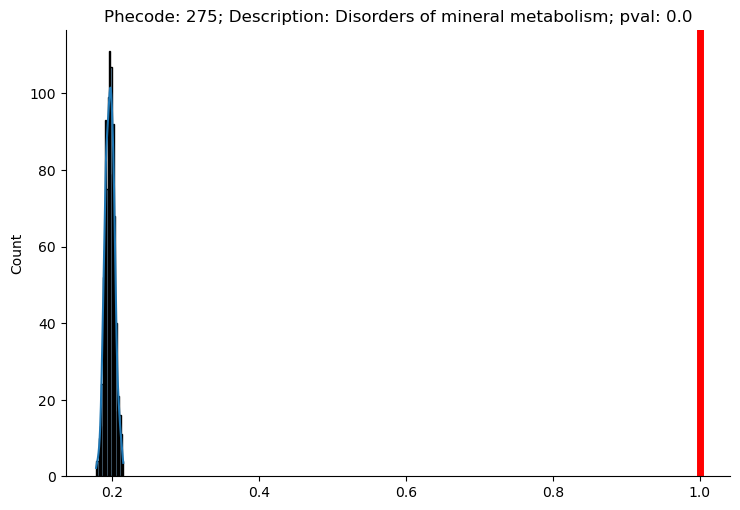

In [29]:
plot_phecode_dist(phecode='275', results_df=results, enriched_phecodes=enriched_phecodes, N=2705)

In [6]:
import pandas as pd

phecode_map = pd.read_csv('/data100t1/home/biand/Projects/Comorbidity_analysis/data/Phecode_map12_filtered.csv', dtype={'Phecode':str})
display(phecode_map.head())

display(phecode_map.shape)

display(phecode_map.columns)

display(phecode_map.loc[phecode_map.Phecode=='A40.0', 'PhecodeString'])

display(phecode_map.loc[phecode_map.Phecode=='A40.0', 'PhecodeString'].values[0])

,ICD,Flag,ICDString,Phecode,PhecodeString,PhecodeCategory
0,001,9,Cholera,008,Intestinal infection,Intestinal infection
1,001.0,9,Cholera due to Vibrio cholerae,008,Intestinal infection,Intestinal infection
2,001.1,9,Cholera due to Vibrio cholerae el tor,008,Intestinal infection,Intestinal infection
3,001.9,9,Cholera NOS,008,Intestinal infection,Intestinal infection
4,002,9,Typhoid and paratyphoid fevers,008,Intestinal infection,Intestinal infection


(105284, 6)

Index(['ICD', 'Flag', 'ICDString', 'Phecode', 'PhecodeString',
       'PhecodeCategory'],
      dtype='object')

Series([], Name: PhecodeString, dtype: object)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [7]:
phecode_map.dtypes

ICD                object
Flag                int64
ICDString          object
Phecode            object
PhecodeString      object
PhecodeCategory    object
dtype: object

# Interpret the model using Shapley value

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import shap
import joblib

/belowshare/vumcshare/data100t1/home/biand/miniforge3/envs/cchc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
phecode_map = pd.read_csv('/data100t1/share/synthetic-deriv/phecodes/ICD_Phecode_mapping.csv', dtype={'Phecode':str})
phecode_map = phecode_map[['Phecode', 'PhecodeString']].drop_duplicates(ignore_index=True)
phecode_map.Phecode = phecode_map.Phecode.apply(lambda x: x.strip())
phecode_map.index = phecode_map.Phecode
phecode_map.drop(columns=['Phecode'], inplace=True)
phecode_map = phecode_map.to_dict()
phecode_map = phecode_map['PhecodeString']
phecode_map

{'008': 'Intestinal infection',
 '008.5': 'Bacterial enteritis',
 '038.1': 'Gram negative septicemia',
 '320': 'Meningitis',
 '480.1': 'Bacterial pneumonia',
 '711': 'Arthropathy associated with infections',
 '710.1': 'Osteomyelitis',
 '008.7': 'Intestinal infection due to protozoa',
 '008.51': 'Intestinal e.coli',
 '008.52': 'Intestinal infection due to C. difficile',
 '008.6': 'Viral Enteritis',
 '010': 'Tuberculosis',
 '041': 'Bacterial infection NOS',
 '686': 'Other local infections of skin and subcutaneous tissue',
 '369': 'Infection of the eye',
 '038.2': 'Gram positive septicemia',
 '031.1': 'Leprosy',
 '031': 'Diseases due to other mycobacteria',
 '465': 'Acute upper respiratory infections of multiple or unspecified sites',
 '420.1': 'Myocarditis',
 '567': 'Peritonitis and retroperitoneal infections',
 '592.1': 'Cystitis',
 '041.2': 'Streptococcus infection',
 '323': 'Encephalitis',
 '420': 'Carditis',
 '420.2': 'Pericarditis',
 '420.3': 'Endocarditis',
 '038': 'Septicemia',
 '

In [41]:
data = pd.read_csv('../data/test_data_for_ML.csv')
X_phecode = data.iloc[:, 1:-1]
# Update X_phecode columns to include descriptions based on phecode_map
X_phecode.columns = [f"{col} ({phecode_map[col]})" if col in phecode_map else col for col in X_phecode.columns]
X_phecode.shape

(557, 174)

In [15]:
rf_model = joblib.load('../results/PheML_RF_test.model')

In [43]:
explainer_phecode = shap.Explainer(rf_model)
shap_values_phecode = explainer_phecode(X_phecode)
# shap.plots.waterfall(shap_values_phecode[0][0])
shap_values_phecode.shape

(557, 174, 2)

In [57]:
def find_index_of_grid(data, grid):
    row_idx = data.index[data['grid']==grid].tolist()
    if len(row_idx) == 0: return None
    else: return row_idx[0]

In [66]:
shap.plots.waterfall(shap_values_phecode[find_index_of_grid(data, 'R200029723'), :, 1], show=False)
plt.title('test')
plt.savefig('../results/waterfall_test.png', bbox_inches='tight')

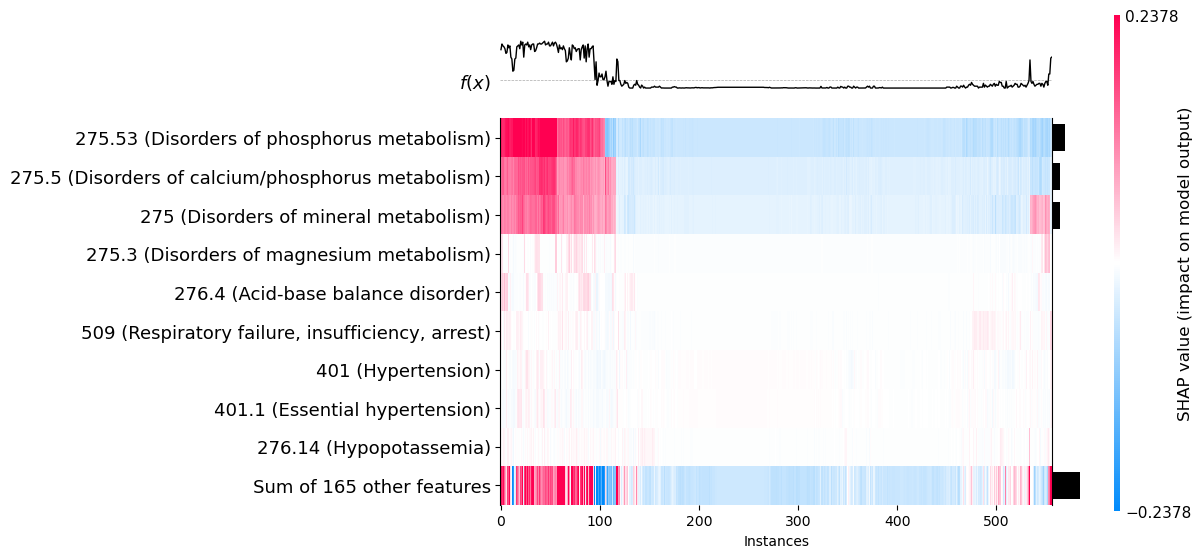

<Axes: xlabel='Instances'>

In [53]:
shap.plots.heatmap(shap_values_phecode[:,:,1])

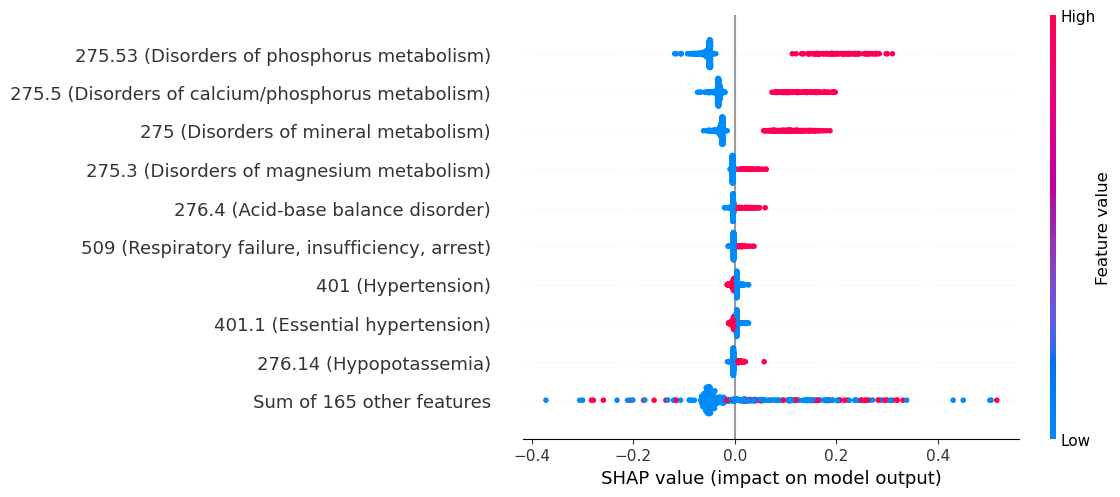

In [54]:
shap.plots.beeswarm(shap_values_phecode[:,:,1])

In [ ]:
shap.initjs()

In [45]:
shap.plots.force(shap_values_phecode[0,:,1])

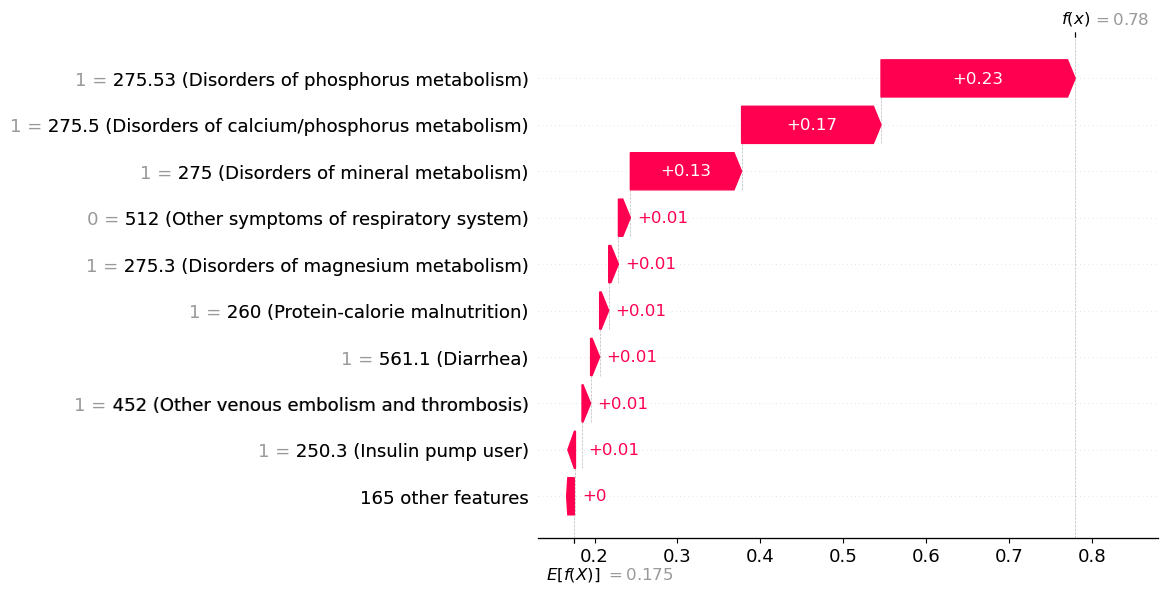

In [75]:
import sys
sys.path.append('../src')
from pheML_develop import interpret_model
from pathlib import Path
interpret_model(rf_model, data, 'R200029723', phecode_map, Path('../results'), 'test', show=True)